# **Politician Tweets Data Analysis**


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
ROOT_PATH = "/Users/lina/DataScience/Project/Yoga/"
PERSONAL_PATH = "Personal/Lina"
sys.path.append(os.path.join(ROOT_PATH, 'src'))
os.chdir(os.path.join(ROOT_PATH, PERSONAL_PATH))
sys.path.append(os.path.join(ROOT_PATH, PERSONAL_PATH))
TRAIN_FPATH = os.path.join(ROOT_PATH, "Data/train_traducido.csv")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
from parties_classification import remove_tweets_with_non_identified_language
from parties_classification import add_text_clean_col_to_df
from parties_classification import get_sentiment_features_df
from parties_classification import get_features_of_interest_counts
from parties_classification import get_language_df
from parties_classification import count_features_and_scale
import files.f3 as funcs
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from sklearn import preprocessing
import datetime as dt
def get_day_week(df):
    df.created_at = pd.to_datetime(df.created_at)
    day_week_i = df['created_at'].dt.day_name()
    enc = preprocessing.LabelEncoder()
    enc.fit(day_week_i)
    day_week = enc.transform(day_week_i)
    ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
    day_week = np.array(day_week)
    day_week = day_week.reshape(-1, 1)
    day_week = ohe.fit_transform(day_week).toarray()
    return pd.DataFrame(day_week)

def get_part_day(df):
    new_hours = df.created_at[df.created_at.dt.hour == 0]
    new_hours2 = new_hours + dt.timedelta(hours=1)
    df.created_at[df.created_at.dt.hour == 0] = new_hours2
    part_day_i = pd.cut(df.created_at.dt.hour, [0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    enc = preprocessing.LabelEncoder()
    enc.fit(part_day_i)
    part_day = enc.transform(part_day_i)
    ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
    part_day = np.array(part_day)
    part_day = part_day.reshape(-1, 1)
    part_day = ohe.fit_transform(part_day).toarray()
    return pd.DataFrame(part_day)


In [5]:
    train_df_tr = pd.read_csv(TRAIN_FPATH, delimiter=';')
    train_df_tr = remove_tweets_with_non_identified_language(train_df_tr)
    train_df_tr = add_text_clean_col_to_df(train_df_tr)
    train_df_counts = get_features_of_interest_counts(train_df_tr)
    train_df_languages = get_language_df(train_df_tr)
    train_df_day_week = get_day_week(train_df_tr)
    train_df_part_day = get_part_day(train_df_tr)
    train_df_sentiment = get_sentiment_features_df(ROOT_PATH, train_df_tr, str='train')
    train_features_count = count_features_and_scale(train_df_tr, train_df_counts)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


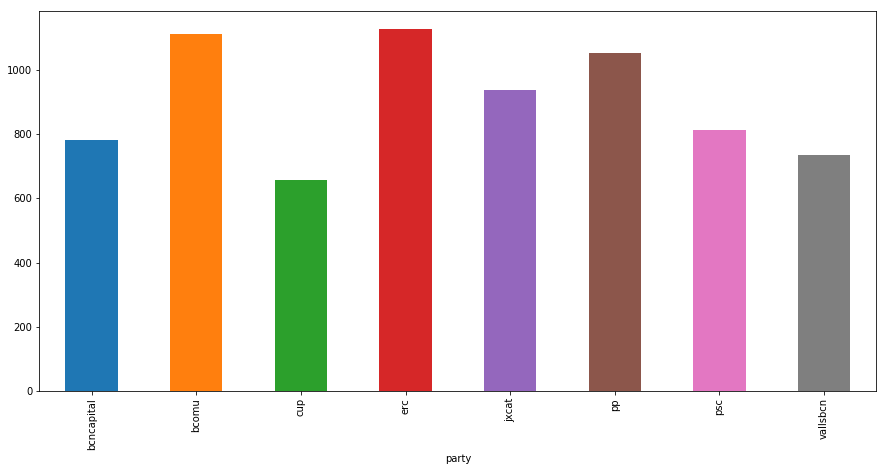

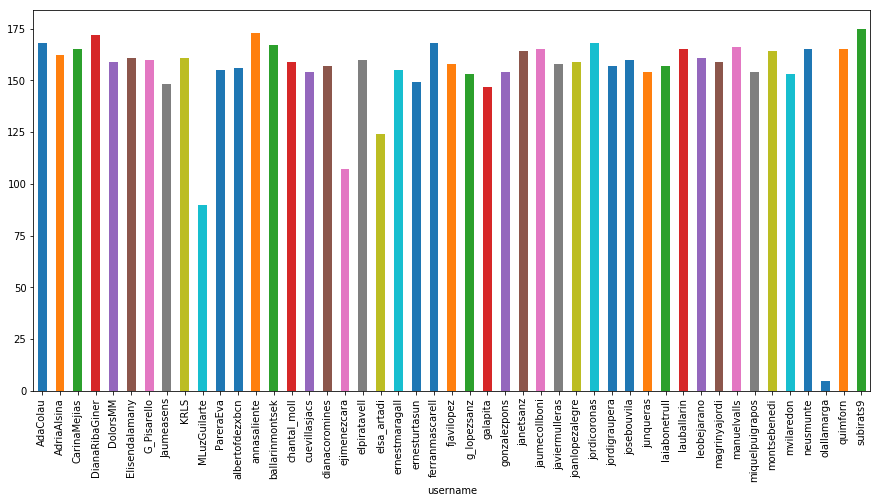

In [40]:
plt.rcParams["figure.figsize"] = [15, 7]
train_df_tr.groupby('party')['text'].count().plot(kind='bar')
plt.show()

fig = train_df_tr.groupby('username')['text'].count().plot(kind='bar')
plt.show()

In the case of politicians the dataset was unbalanced, in order to have a similar amount of classes we duplicated the tweets until all classes reache 175. 

In [ ]:
def get_balanced_usernames_data(df):
    y = df['username'].values
    values, tweet_counts = np.unique(y, return_counts=True)
    politicians = pd.DataFrame({'values': values,
                                'tweet_counts': tweet_counts})
    max_tweet = np.max(politicians['tweet_counts'])
    pol_df_total = df.iloc[0:0]
    for pol in politicians['values']:
        pol_df = df[df.username == pol]
        if pol == 'olallamarga':
            pol_df = pol_df.loc[pol_df.index.repeat(20)]
        pol_df = pd.concat([pol_df, pol_df[0:max_tweet - len(pol_df)]], axis=0)
        pol_df_total = pd.concat([pol_df_total, pol_df], axis=0)

    pol_df_total.reset_index(inplace=True, drop=True)
    df = pol_df_total.copy()

    return df

## Text Representation

We use bag of words and td-idf meassure for extracting features from text. 

The parameters of the TfidfVectorizer function were optimized to get the most accurate predictions. Stemming process was also used and stop_words is set to *spanish*.

In [3]:
tfidf_vectorizer = funcs.StemmedTfidfVectorizer(
        sublinear_tf=True,
        max_df=0.25,
        min_df=3,
        norm='l2',
        stop_words=funcs.stop_words(),
        ngram_range=(1, 1)
        )

Additionally, we included some other features extracted from the dataset:
 - **Language:** This feature contains the language information in which the tweet was written (catalan, spanish, english or other).
 - **Counts:** This feature counts the number of *retweet_count*, *favorite_count*, emoticons, hashtags, mentions and words used in each tweet.
 - **Day week:** This feature gives information about the day of the week in which the tweet was written.
 - **Part day:** This feature gives information about the part of the day in which the tweet was written (morning, afternoon, evening or night).
 - **Sentiment:** This feature contains information about the sentiment of the tweet (positive, negative or neutral).

In [6]:
X_tfidf = tfidf_vectorizer.fit_transform(train_df_tr['text_clean']).toarray()
X_tfidf = np.append(X_tfidf, train_df_languages, 1)
X_tfidf = np.append(X_tfidf, train_features_count, 1)
X_tfidf = np.append(X_tfidf, train_df_day_week, 1)
X_tfidf = np.append(X_tfidf, train_df_part_day, 1)
X_tfidf = np.append(X_tfidf, train_df_sentiment, 1)
print("Train:",X_tfidf.shape)

X_tfidf_test = tfidf_vectorizer.transform(test_df_tr['text_clean']).toarray()
X_tfidf_test = np.append(X_tfidf_test, test_df_languages, 1)
X_tfidf_test = np.append(X_tfidf_test, test_features_count, 1)
X_tfidf_test = np.append(X_tfidf_test, test_df_day_week, 1)
X_tfidf_test = np.append(X_tfidf_test, test_df_part_day, 1)
X_tfidf_test = np.append(X_tfidf_test, test_df_sentiment, 1)
fill_nan_in_matrix(X_tfidf_test, value=0.5)
print("Test:",X_tfidf_test.shape)

Train: (7216, 4972)


Each of 7216 tweets is represented by 4972 features. The test dataset is also transformed to tf-idf vectores and represented with the same features.

## Model Selection

After having vector representations of the text we can train some supervised classifiers. First, we enconde the *y* labels and split the trainning dataset to test our models.

In [7]:
le = LabelEncoder()
y_encode = le.fit_transform(train_df_tr['party'])
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_tfidf,
                                                                                 y_encode,
                                                                                 train_df_tr.index,
                                                                                 test_size=0.25)

The next function will evaluate each model and the combination of them by the ensembles, Max Voting and Stacking. We also use a Sequential Keras model with the KerasClassifier module which implements the sklearn classifier interface. The hyper-parameters of each model were tuned to get the most accurate predictions.

VotingClassifier module in sklearn implements the Max Voting ensemble, in which the models are used to make predictions for each tweet. The classifications we get from the majority of the models are used as the final prediction.

Stacking is a technique that uses the predictions from multiple models to build a new model. Each of the models is fitted in n-1 parts of the train dataset and the last part of this set is used to make the predictions. Next, the model is fitted on the whole train set and the predictions are made on the test set. Finally, the predictions obtained from the train set of all the models are used as features of a new model and this one is used to make the final predictions.

In [10]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from vecstack import stacking
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers, regularizers
from keras.layers import Dropout,Dense,Activation
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

def Sequential_model(input_dim, n_classes):
  def sm():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
  return sm


def model_sel(x_train, y_train, x_test, y_test):

    clf1 = LogisticRegression(random_state=0)
    clf2 = BernoulliNB()
    clf3 = SVC(C = 1, kernel = 'linear')
    clf4 = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=1, 
                                  max_features='sqrt',max_depth=100, bootstrap=False)
    clf5 = xgb.XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.3,
                             n_estimators=100, max_depth=4)
    clf6 = neighbors.KNeighborsClassifier(n_neighbors=9,p=1)
    clf7 = GradientBoostingClassifier(max_depth=5, min_samples_split=4, min_samples_leaf=1, subsample=1,
                                      max_features='sqrt', random_state=10,
                                      learning_rate = 0.15, n_estimators = 300)
    clf8 = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                             learning_rate=1, n_estimators=200, random_state=1)

    input_dim = x_train.shape[1]
    n_classes = len(np.unique(y_train))
    clf9 = KerasClassifier(Sequential_model(input_dim, n_classes),epochs=8)

    clf = [clf1, clf2, clf3, clf4,clf5,clf6,clf7,clf8,clf9]
    results = []
    
    for model in clf:
        print(f"Classifier: {model}")
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        results.append((model.__class__.__name__,score))
        print("score: {}".format(score))
        print(" ")


    print("Ensembles.................................")
    print(" ")

    #Max Voting
    MaxVoting_esemble = VotingClassifier(estimators=[('lr', clf1), ('bb', clf2), ('svc', clf3), ('rf', clf4), 
                                                     ('xg', clf5), ('knn', clf6), ('grb', clf7), ('ab', clf8), 
                                                     ('nn',clf9)], voting='hard')
    MaxVoting_esemble.fit(x_train,y_train)
    score = MaxVoting_esemble.score(x_test,y_test)
    results.append(("MaxVoting",score))
    print("MaxVoting: {}".format(score))
    print(" ")

    #staking
    S_train, S_test = stacking(clf,                   
                           x_train, y_train, x_test,   
                           regression=False,      
                           mode='oof_pred_bag',        
                           needs_proba=False,         
                           save_dir=None,             
                           metric=accuracy_score,     
                           n_folds=4,                  
                           stratified=True,            
                           shuffle=True,             
                           random_state=0,           
                           verbose=2)

    stacking_ensemble = SVC(C= 1, kernel= 'linear')
    stacking_ensemble = stacking_ensemble.fit(S_train, y_train)
    stacking_score = stacking_ensemble.score(S_test, y_test)
    results.append(("Stacking",stacking_score))
    print("Stacking: {}".format(stacking_score))
    
    df_models = pd.DataFrame(results, columns=['Model','Score'])

    return clf, MaxVoting_esemble, stacking_ensemble, df_models

In [11]:
models, maxVote, Stacking, df_models = model_sel(X_train, y_train, X_test, y_test)

Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
score: 0.4772727272727273
 
Classifier: BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
score: 0.6130820399113082
 
Classifier: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
score: 0.49057649667405767
 
Classifier: RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_e

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


score: 0.614190687361419
 
Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=1,
           weights='uniform')
score: 0.17516629711751663
 
Classifier: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=10, subsample=1, verbose=0,
              warm_start=False)
score: 0.6130820399113082
 
Classifier: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=200, random_state=1)
score: 0.3946784922394678
 
Classifier: <keras.wrappers.scikit_learn.KerasClassifier object at 0x1a2e2c9fd0>
Instructions fo

KeyboardInterrupt: 

Let's compare the results of the trained models

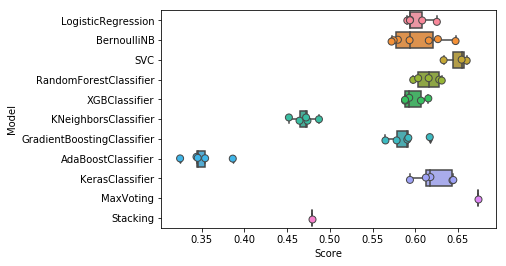

Model
MaxVoting                     0.672949
SVC                           0.649239
KerasClassifier               0.622405
RandomForestClassifier        0.615157
LogisticRegression            0.602363
BernoulliNB                   0.601357
XGBClassifier                 0.598179
GradientBoostingClassifier    0.588569
Stacking                      0.479490
KNeighborsClassifier          0.469963
AdaBoostClassifier            0.350851
Name: Score, dtype: float64

In [32]:
import pickle
df_models = pickle.load(open('df_models.sav', 'rb'))

import seaborn as sns
sns.boxplot(x='Score', y='Model', data=df_models)
sns.stripplot(x="Score", y="Model", data=df_models, jitter=True, size=7, edgecolor="gray", linewidth=1)
plt.show()

df_models.groupby('Model').Score.mean().sort_values(ascending=False)

From the single classifiers we can see that SVC is the best estimator and the worst is AdaBoostClassifier. The latter should improve with a better week learner, in this case we used the default one. 

The ensemble Max Voting performs better than any other classifier, and Stacking performs poorly mainly due to the fact that this method has many hyper-parameters to be optimized (type and number of estimators to use, number of stacking levels, etc.).

We choose the Max Voting procedure to train all the data and make the predictions.

In [ ]:
maxVote.fit(X_tfidf, y_encode)
predictions = maxVote.predict(X_tfidf_test)
predictions_ = np.argmax(to_categorical(predictions), axis=1)
predictions_ = le.inverse_transform(predictions_)

In [ ]:
## Create the results file ##
funcs.save_submission(predictions_, "yoga_submission")